# **Setting Up and Using the AniList API**

### **Tip 1**: Use a virtual environment to keep your dependencies isolated.  
### **Tip 2**: Don’t worry about tokens expiring—they last a long time.

---

## **Step 1: Register Your Application on AniList**

1. **Go to AniList Developer Settings**:  
   - [AniList Developer Settings](https://anilist.co/settings/developer).
   - [Heres the docs aswell](https://docs.anilist.co/guide/graphql/).

2. **Create a New Application**:
   - If you don’t have an AniList account, create one.
   - **Application Name**: Choose a memorable name.
   - **Redirect URL**: Use a dummy URL like `https://example.com/callback`.  
     *(No web development is needed; this is just for OAuth).*

3. **Save the Application**:
   - You’ll receive:
     - **Client ID**
     - **Client Secret**
   - **Important**: Save these securely.
---

## **Step 2: Obtain an Authorization Code**

### **Why Use Authorization Code Grant?**
We’ll hide sensitive keys in a `.env` file and add it to `.gitignore` for security.

### **Construct the Authorization URL**  
Replace placeholders with your actual values:
https://anilist.co/api/v2/oauth/authorize?client_id=YOUR_CLIENT_ID&response_type=code&redirect_uri=YOUR_REDIRECT_URI


### 1. **Open the URL in a Browser**

- Log in to AniList.
- Grant permissions to your app.
- You’ll be redirected to your specified redirect URL, which includes the AUTH_CODE as a query parameter (e.g., https://example.com/callback?code=AUTH_CODE).


#### 2. **Copy the `AUTH_CODE` from the Redirect URL and save it to the `.env` file**



## **Step 3: Exchange Authorization Code for Access Token**

1. **Create a `.env` File**:  
   Store your credentials securely in the following format:

   CLIENT_ID="{INSERT}"

   CLIENT_SECRET="{INSERT}"

   REDIRECT_URI="{INSERT}"
   
   AUTH_CODE="{INSERT}"

2. **Run the First Code Cell**:

This makes a POST request to AniList's `token_url` and retrieves the `ACCESS_TOKEN`


In [2]:
import requests
import os
from dotenv import load_dotenv

# Load variables from .env file
load_dotenv()

# Access the environment variables
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET')
REDIRECT_URI = os.getenv('REDIRECT_URI')
ACCESS_TOKEN = os.getenv('ACCESS_TOKEN')
AUTH_CODE = os.getenv('AUTH_CODE')

# Token request payload
token_url = 'https://anilist.co/api/v2/oauth/token' # public endpoint for Anilist 
payload = {
    'grant_type': 'authorization_code',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    'redirect_uri': REDIRECT_URI,
    'code': AUTH_CODE
}

# Send POST request to exchange code for access token
response = requests.post(token_url, data=payload)
token_data = response.json()

# Print the access token

# Uncomment this, doesn't work after a couple of tries to mark down result
#print("Access Token:", token_data['access_token'])

3. **Add the ACCESS_TOKEN to Your .env File:**
    
    ACCESS_TOKEN="{INSERT}"

4. **Testing json data**

    Now run the cell below to test if you can fetch the anime json data


In [3]:
import requests

# Your access token
ACCESS_TOKEN = os.getenv('ACCESS_TOKEN')

# Authorization headers
headers = {
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}

# GraphQL query to fetch anime details
query = '''
query ($id: Int) {
  Media(id: $id, type: ANIME) {
    id
    title {
      romaji
      english
      native
    }
    format
    episodes
    status
    averageScore
    popularity
    genres
  }
}
'''

# Variables for the query
variables = {
    'id': 1  # Example ID for "Cowboy Bebop"
}

# Make the request
url = 'https://graphql.anilist.co'
response = requests.post(url, json={'query': query, 'variables': variables}, headers=headers)

# Print the response
print(response.json())


{'data': {'Media': {'id': 1, 'title': {'romaji': 'Cowboy Bebop', 'english': 'Cowboy Bebop', 'native': 'カウボーイビバップ'}, 'format': 'TV', 'episodes': 26, 'status': 'FINISHED', 'averageScore': 86, 'popularity': 372252, 'genres': ['Action', 'Adventure', 'Drama', 'Sci-Fi']}}}


The result for the last response should be 

{'data': {'Media': {'id': 1, 'title': {'romaji': 'Cowboy Bebop', 'english': 'Cowboy Bebop', 'native': 'カウボーイビバップ'}, 'format': 'TV', 'episodes': 26, 'status': 'FINISHED', 'averageScore': 86, 'popularity': 372155, 'genres': ['Action', 'Adventure', 'Drama', 'Sci-Fi']}}}



The goal of this project is to train a machine learning model using data collected from the AniList API to predict an anime's true rating based on a variety of factors. The features used in the training process include attributes such as studio, number of episodes, season, popularity, favorites, and other relevant metrics.

At the end of the project, the model should be able to take a valid anime title as input, calculate its predicted "true rating," and compare the result to the original rating listed on AniList. This approach aims to provide insights into how various factors contribute to an anime's rating and evaluate the model's predictive performance.

In [4]:
# Anilist Fetching animes and making CSV file 
import requests
import random
import time
import pandas as pd
from dotenv import load_dotenv
import os

# Load environment variables from .env
load_dotenv()

# Your AniList access token
ACCESS_TOKEN = os.getenv('ACCESS_TOKEN')

# Authorization headers
headers = {
    'Authorization': f'Bearer {ACCESS_TOKEN}'
}

# GraphQL query to fetch anime details (only TV format)
query = '''
query ($page: Int, $perPage: Int) {
  Page(page: $page, perPage: $perPage) {
    media(type: ANIME, format: TV) {
      id
      title {
        romaji
        english
      }
      episodes
      status
      averageScore
      popularity
      favourites
      genres
      studios {
        edges {
          node {
            name
          }
        }
      }
      source
      season
      startDate {
        year
        month
        day
      }
      endDate {
        year
        month
        day
      }
    }
  }
}
'''

# Anilist Fetching animes and making CSV file
def fetch_anime_details(total_anime=500, animes_per_page=50):
    anime_list = []
    current_page = 1

    while len(anime_list) < total_anime:
        # Variables for the query
        variables = {
            'page': current_page,
            'perPage': animes_per_page
        }

        # Make the request
        url = 'https://graphql.anilist.co'
        response = requests.post(url, json={'query': query, 'variables': variables}, headers=headers)

        if response.status_code == 200:
            data = response.json()
            fetched_anime = data['data']['Page']['media']
            anime_list.extend(fetched_anime)
            
            # Stop if there are no more anime to fetch
            if len(fetched_anime) < animes_per_page:
                print("Reached the end of available anime.")
                break
        elif response.status_code == 429:  # Too Many Requests Error
            print(f"Rate limit hit. Waiting for 60 seconds...")
            time.sleep(60)  # Wait longer when rate-limited
            continue
        else:
            print(f"Error fetching page {current_page}: {response.status_code}, {response.text}")
            break

        # Delay to respect API limits
        time.sleep(1)
        current_page += 1

    # Trim the list to the requested total_anime count
    anime_list = anime_list[:total_anime]

    print(f"Total anime fetched: {len(anime_list)}")
    return anime_list

# Fetch anime details
total_anime_to_fetch = 2000 # How many animes you want
animes_per_page = 50 
# Higher animes_per_page: 
# A single request retrieves more data, reducing the total number of API calls. 
# However, larger payloads take longer to process on both the API server and your client.
anime_data = fetch_anime_details(total_anime=total_anime_to_fetch, animes_per_page=animes_per_page)

# Process the data into a DataFrame
processed_anime_data = []

for anime in anime_data:
    studios = ", ".join([studio['node']['name'] for studio in anime['studios']['edges']])
    start_date = f"{anime['startDate']['year']}-{anime['startDate']['month']}-{anime['startDate']['day']}" if anime['startDate'] else None
    end_date = f"{anime['endDate']['year']}-{anime['endDate']['month']}-{anime['endDate']['day']}" if anime['endDate'] else None
    processed_anime_data.append({
        'id': anime['id'],
        'title_romaji': anime['title']['romaji'],
        'title_english': anime['title']['english'],
        'episodes': anime['episodes'],
        'status': anime['status'],
        'average_score': anime['averageScore'],
        'popularity': anime['popularity'],
        'favourites': anime['favourites'],
        'genres': ", ".join(anime['genres']),
        'studios': studios,
        'source': anime['source'],
        'season': anime['season'],
        'start_date': start_date,
        'end_date': end_date
    })

df = pd.DataFrame(processed_anime_data)

# Save to CSV
df.to_csv('data/raw_anilist.csv', index=False)
print(f"Fetched {total_anime_to_fetch} TV anime and saved to 'data/raw_anilist.csv'")

Rate limit hit. Waiting for 60 seconds...
Total anime fetched: 2000
Fetched 2000 TV anime and saved to 'data/raw_anilist.csv'


In [7]:
# lets view our rows to make sure everything is there 
file_path = 'data/raw_anilist.csv'
print(pd.read_csv(file_path, nrows=15))


    id                title_romaji           title_english  episodes  \
0    1                Cowboy Bebop            Cowboy Bebop      26.0   
1    6                      TRIGUN                  Trigun      26.0   
2    7          Witch Hunter ROBIN      Witch Hunter ROBIN      26.0   
3    8              Bouken Ou Beet  Beet the Vandel Buster      52.0   
4   15                Eyeshield 21            Eyeshield 21     145.0   
5   16        Hachimitsu to Clover        Honey and Clover      24.0   
6   17  Hungry Heart: Wild Striker                     NaN      52.0   
7   18      Initial D FOURTH STAGE     Initial D 4th Stage      24.0   
8   19                     MONSTER                 Monster      74.0   
9   20                      NARUTO                  Naruto     220.0   
10  21                   ONE PIECE               ONE PIECE       NaN   
11  22         Tennis no Ouji-sama    The Prince of Tennis     178.0   
12  23            Ring ni Kakero 1                     NaN      

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load the dataset
# Specify the file path for the dataset containing anime details
file_path = 'data/raw_anilist.csv'
data = pd.read_csv(file_path)

# Step 2: Split the data into training and testing sets
# Use an 80-20 split: 80% of the data will be used for training, 20% for testing
# random_state ensures reproducibility of the split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Step 3: Save the splits to separate CSV files
# Save the training data to 'train.csv' for model training
train_data.to_csv('data/train.csv', index=False) # Ensure the index is not included in the saved file
# Save the testing data to 'test.csv' for model evaluation
test_data.to_csv('data/test.csv', index=False)

# Step 4: Confirmation message
print("Data split completed. 'train.csv' and 'test.csv' have been saved.")

Data split completed. 'train.csv' and 'test.csv' have been saved.


In [9]:
import pandas as pd # Import the pandas library for data manipulation and analysis
# Step 1: Define file paths for training and testing data
# Specify the file paths for the training and testing datasets
train_path = 'data/train.csv'
test_path = 'data/test.csv'

# Step 2: Load the data into DataFrames
# Use pandas to read the CSV files and load them into DataFrames
train_df = pd.read_csv(train_path) # Load the training dataset into 'train_df'
test_df = pd.read_csv(test_path) # Load the testing dataset into 'test_df'

# At this point, 'train_df' contains the data for training the model,
# and 'test_df' contains the data for evaluating the model.

In [10]:
import numpy as np
def preprocess_and_engineer_features(df):
    # Convert start and end dates to datetime
    df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
    df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

    # Extract year from start date
    df['start_year'] = df['start_date'].dt.year.fillna(0).astype(int)
    df['end_year'] = df['end_date'].dt.year.fillna(0).astype(int)

    # Encode season numerically (e.g., SPRING = 1, SUMMER = 2, etc.)
    season_mapping = {'WINTER': 1, 'SPRING': 2, 'SUMMER': 3, 'FALL': 4}
    df['season_encoded'] = df['season'].map(season_mapping).fillna(0).astype(int)

    # Calculate anime runtime in days
    df['runtime_days'] = (df['end_date'] - df['start_date']).dt.days.fillna(0).astype(int)

    # Log-transform numerical features to reduce skewness
    df['log_popularity'] = np.log1p(df['popularity'])
    df['log_favorites'] = np.log1p(df['favourites'])

    # One-hot encode genres (can handle multiple genres per anime)
    df['genres'] = df['genres'].str.split(', ')  # Split genres into lists
    genre_dummies = df['genres'].explode().str.get_dummies().groupby(level=0).sum()
    df = pd.concat([df, genre_dummies], axis=1)

    # Studios encoding (use a frequency encoding)
    studio_counts = df['studios'].value_counts().to_dict()
    df['studio_frequency'] = df['studios'].map(studio_counts).fillna(0)

    return df

In [423]:
# Preprocess datasets
train_df = preprocess_and_engineer_features(train_df)
test_df = preprocess_and_engineer_features(test_df)

In [11]:
train_df.head(1)

,id,title_romaji,title_english,episodes,status,average_score,popularity,favourites,genres,studios,source,season,start_date,end_date
0,2562,Shion no Ou: The Flowers of Hard Blood,NaN,22.0,FINISHED,71.0,5920,39,"Drama, Mystery, Thriller","Studio DEEN, Yomiko Advertising, Pony Canyon, ...",MANGA,FALL,2007-10-14,2008-3-23


In [12]:
test_df.head(1)

,id,title_romaji,title_english,episodes,status,average_score,popularity,favourites,genres,studios,source,season,start_date,end_date
0,9314,Fractale,Fractale,11.0,FINISHED,65.0,15065,80,"Adventure, Fantasy, Sci-Fi","A-1 Pictures, Funimation, Ordet, Asmik Ace, So...",ORIGINAL,WINTER,2011-1-14,2011-4-1


In [1]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# Load your data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Define target and features
target = 'average_score'
features = train_df.drop(columns=['id', 'start_date', 'end_date', target])  # Drop unnecessary columns
test_features = test_df.drop(columns=['id', 'start_date', 'end_date', target])
y_train_full = train_df[target]

# Handle missing values in target
if y_train_full.isnull().sum() > 0:
    print("Missing values found in target. Dropping rows with NaN targets.")
    # Drop rows with NaN in target
    train_df = train_df.dropna(subset=[target])
    y_train_full = train_df[target]
    features = train_df.drop(columns=['id', 'start_date', 'end_date', target])  # Re-align features

# Identify numerical and categorical columns
numerical_cols = features.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = features.select_dtypes(include=['object']).columns

# Define preprocessors
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing numerical values
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Preprocess datasets
X_train_full = features
X_test_full = test_features

if X_train_full.isnull().sum().sum() > 0:
    print("Missing values found in features. Preprocessing will handle them.")

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Preprocess features
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test_full)

# Train the model (XGBoost Regressor)
model = XGBRegressor(
    n_estimators=1000,
    max_depth=20,
    learning_rate=0.3,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluate the model
y_val_pred = model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

# Predict on the test dataset
test_predictions = model.predict(X_test)

# Create a submission file
submission = test_df.copy()
submission['true_rating'] = test_predictions
submission[['title_romaji', 'average_score', 'true_rating']].to_csv('data/submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")

Missing values found in target. Dropping rows with NaN targets.
Missing values found in features. Preprocessing will handle them.
Validation MAE: 3.2943
Validation RMSE: 4.2940
Submission file 'submission.csv' created successfully.


In [427]:
submission_df = pd.read_csv('data/submission.csv')
# Replace 'column_name' with the actual column you want to view
print(submission_df.head(10))
print("")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")


                 title_romaji  average_score  true_rating
0                    Fractale           65.0    66.659850
1                PetoPeto-san           59.0    54.018055
2           Youkai Ningen Bem           59.0    59.441513
3    Transformers: Car Robots           58.0    62.717350
4          Hoshi no ko Chobin           47.0    57.640835
5               Play Ball 2nd           57.0    52.725730
6            School Days (TV)           49.0    58.521202
7  Ikkitousen: XTREME XECUTOR           63.0    65.709540
8             Akazukin Chacha           69.0    70.263880
9           Thunderbirds 2086           54.0    52.538400

Validation MAE: 3.2943
Validation RMSE: 4.2940


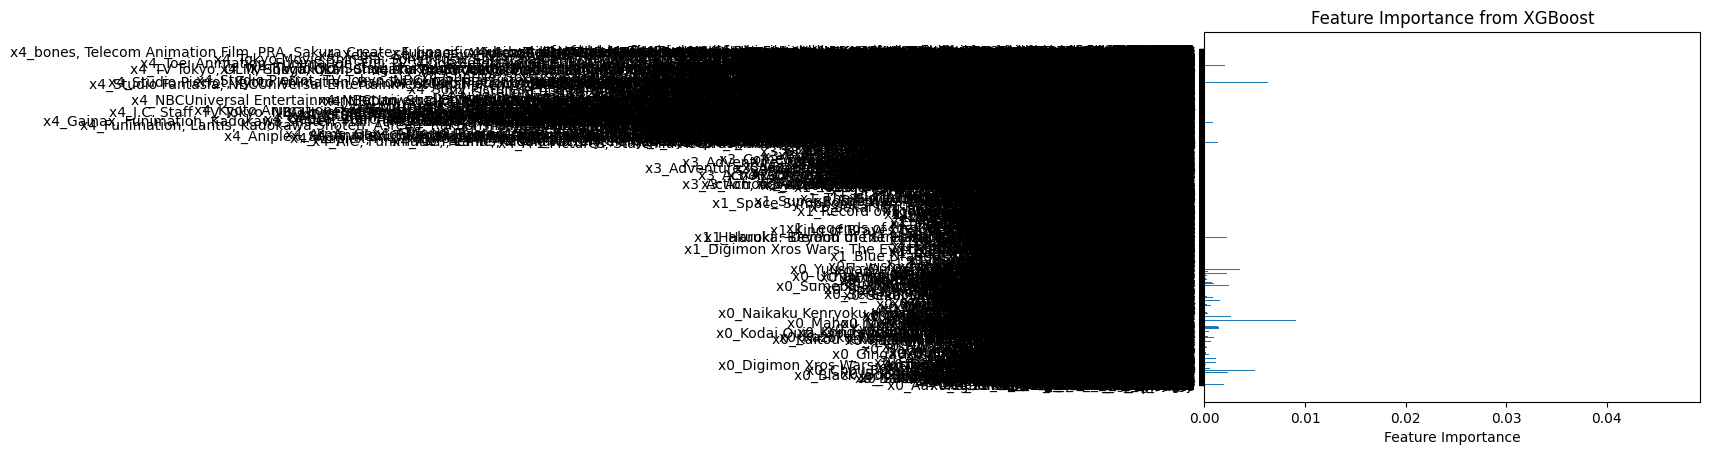

In [428]:
import matplotlib.pyplot as plt

# Feature importance
feature_importances = model.feature_importances_
plt.barh(range(len(feature_importances)), feature_importances)
plt.yticks(range(len(feature_importances)), numerical_cols.tolist() + list(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out()))
plt.xlabel("Feature Importance")
plt.title("Feature Importance from XGBoost")
plt.show()


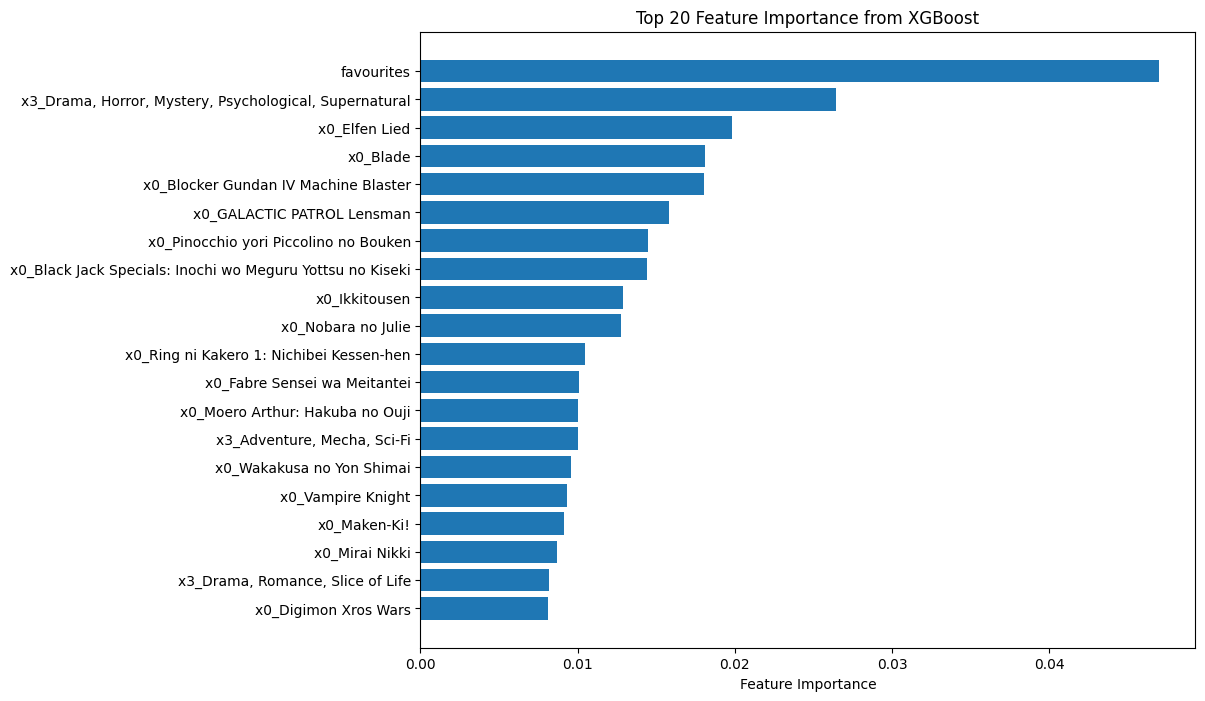

In [429]:
import numpy as np
import matplotlib.pyplot as plt

# Feature importance
feature_importances = model.feature_importances_

# Combine numerical and categorical feature names
feature_names = numerical_cols.tolist() + list(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out())

# Create a sorted index for the top N features
N = 20  # Number of top features to display
sorted_idx = np.argsort(feature_importances)[-N:]

# Plot top N feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Feature Importance")
plt.title(f"Top {N} Feature Importance from XGBoost")
plt.show()


In [430]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import time

# Load your data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Define target and features
target = 'average_score'
features = train_df.drop(columns=['id', 'start_date', 'end_date', target])  # Drop unnecessary columns
test_features = test_df.drop(columns=['id', 'start_date', 'end_date', target])
y_train_full = train_df[target]

# Handle missing values in target
if y_train_full.isnull().sum() > 0:
    print("Missing values found in target. Dropping rows with NaN targets.")
    # Drop rows with NaN in target
    train_df = train_df.dropna(subset=[target])
    y_train_full = train_df[target]
    features = train_df.drop(columns=['id', 'start_date', 'end_date', target])  # Re-align features

# Feature Engineering
# Log Transformation
train_df['log_popularity'] = np.log1p(train_df['popularity'])
train_df['log_favourites'] = np.log1p(train_df['favourites'])
test_df['log_popularity'] = np.log1p(test_df['popularity'])
test_df['log_favourites'] = np.log1p(test_df['favourites'])

# Interaction Features
train_df['popularity_x_favourites'] = train_df['log_popularity'] * train_df['log_favourites']
test_df['popularity_x_favourites'] = test_df['log_popularity'] * test_df['log_favourites']

# Update features after adding engineered columns
features = train_df.drop(columns=['id', 'start_date', 'end_date', target])
test_features = test_df.drop(columns=['id', 'start_date', 'end_date', target])

# Identify numerical and categorical columns
numerical_cols = features.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = features.select_dtypes(include=['object']).columns

# Define preprocessors
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing numerical values
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Preprocess datasets
X_train_full = features
X_test_full = test_features

if X_train_full.isnull().sum().sum() > 0:
    print("Missing values found in features. Preprocessing will handle them.")

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Preprocess features
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test_full)

# Define model with default parameters for hyperparameter tuning
model = XGBRegressor(
    tree_method='hist',  
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


# Define hyperparameter grid
param_grid = {
    'n_estimators': [500, 1000],  # Fewer options for faster search
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define custom RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Perform grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=3,  # Reduced folds for faster search
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

# Train grid search model
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
print(f"Grid search completed in {end_time - start_time:.2f} seconds")

# Get best model and parameters
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate on validation set
y_val_pred = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

# Predict on the test dataset
test_predictions = best_model.predict(X_test)

# Create a submission file
submission = test_df.copy()
submission['true_rating'] = test_predictions
submission[['title_romaji', 'average_score', 'true_rating']].to_csv('data/submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")

Missing values found in target. Dropping rows with NaN targets.
Missing values found in features. Preprocessing will handle them.
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Grid search completed in 365.14 seconds
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 1.0}
Validation MAE: 3.2172
Validation RMSE: 4.1791
Submission file 'submission.csv' created successfully.
